In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
data_name = 'Pancreas_with_cc'

2024-01-02 16:26:31.452733: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 16:26:31.564132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 16:26:31.564168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 16:26:31.565824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 16:26:31.578562: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 16:26:31.579886: I tensorflow/core/platform/cpu_feature_guard.cc:1

You need to change this to suitable directories on your system:

In [2]:
# Data name, where to download data and where to save results
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/Pancreas_with_cc/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/'

In [3]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                    min_shared_counts = 10, n_var_genes= 2000)

Keeping at most 100000 cells per cluster
Filtered out 19641 genes that are detected 10 counts (shared).
Extracted 2000 highly variable genes.


<AxesSubplot:title={'center':'clusters'}, xlabel='UMAP1', ylabel='UMAP2'>

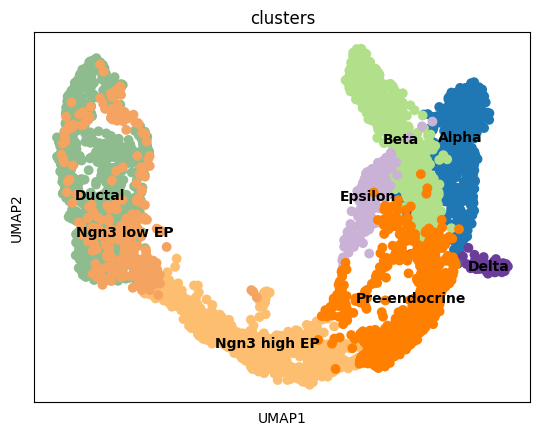

In [4]:
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False)

We initialize the model, which includes automatically setting a maximal number of modules, based on the number of Louvain clusters (times 1.15) in the data.

In [5]:
c2f.Cell2fate_DynamicalModel_amortized.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
n_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...
Number of Leiden Clusters: 13
Maximal Number of Modules: 14


In [7]:
mod = c2f.Cell2fate_DynamicalModel_amortized(adata, n_modules = n_modules)

In [8]:
import pytorch_lightning
pytorch_lightning.__version__
# **{'training_plan' : LowLevelPyroTrainingPlan}

'1.5.10'

In [9]:
mod.train(batch_size = 1000, max_epochs = 1000, lr = 0.01,
         early_stopping = True, early_stopping_min_delta = 10**(-4),
         early_stopping_monitor = 'elbo_train', early_stopping_patience = 45)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 789/1000:  79%|██████████████████████████████████████████████████████████████████████████████████                      | 789/1000 [16:49<04:29,  1.28s/it, v_num=1, elbo_train=6.86e+6]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 6848984.500. Signaling Trainer to stop.


In [10]:
sample_kwarg = {"num_samples": 10, "batch_size" : adata.n_obs,
                 "use_gpu" : False, 'return_samples': False}
adata = mod.export_posterior(adata, sample_kwargs=sample_kwarg)

Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:03<00:00, 13.74s/it]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

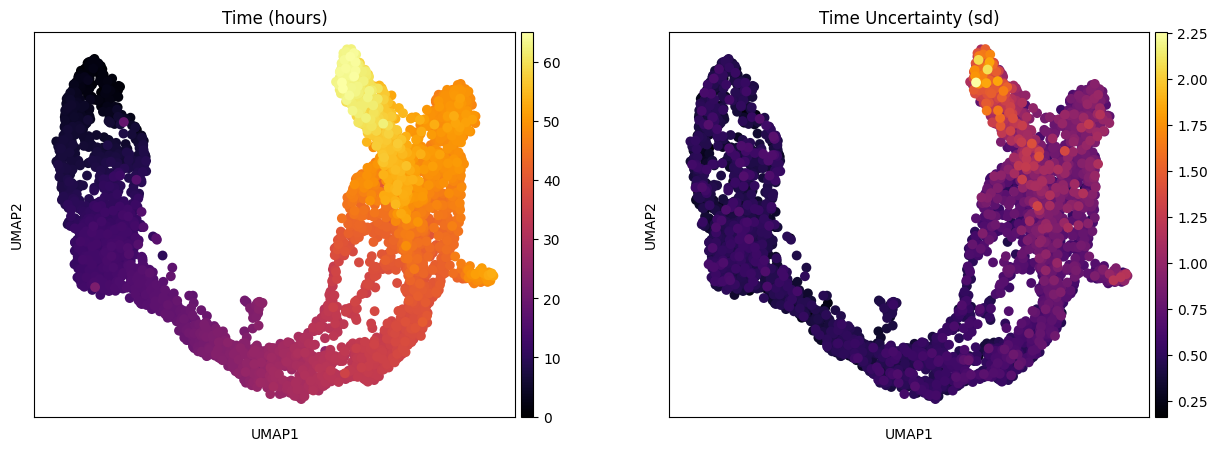

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time_nModules' + str(n_modules) + '.pdf')

In [12]:
mod.module.guide

AutoAmortisedHierarchicalNormalMessenger(
  (locs): PyroModule()
  (scales): PyroModule()
  (weights): PyroModule()
  (one_encoder): FCLayersPyro(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=4000, out_features=15, bias=True)
        (2): None
        (3): LayerNorm((15,), eps=1e-05, elementwise_affine=False)
        (4): ELU(alpha=1.0)
      )
    )
  )
  (hidden2locs): PyroModule(
    (t_c): PyroLinear(in_features=15, out_features=1, bias=True)
    (detection_y_c): PyroLinear(in_features=15, out_features=1, bias=True)
  )
  (hidden2scales): PyroModule(
    (t_c): PyroLinear(in_features=15, out_features=1, bias=True)
    (detection_y_c): PyroLinear(in_features=15, out_features=1, bias=True)
  )
  (hidden2weights): PyroModule(
    (t_c): PyroLinear(in_features=15, out_features=1, bias=True)
    (detection_y_c): PyroLinear(in_features=15, out_features=1, bias=True)
  )
)

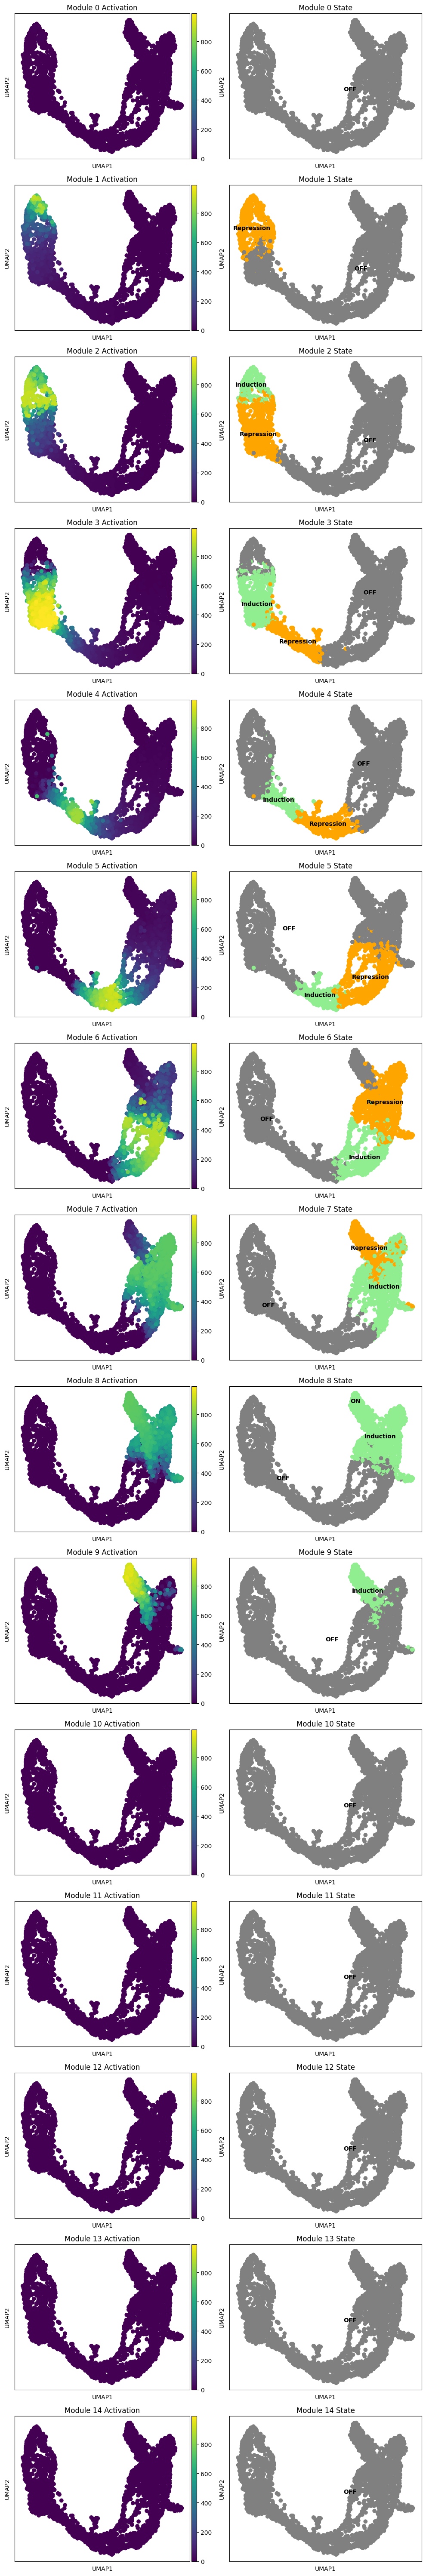

In [13]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata)

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

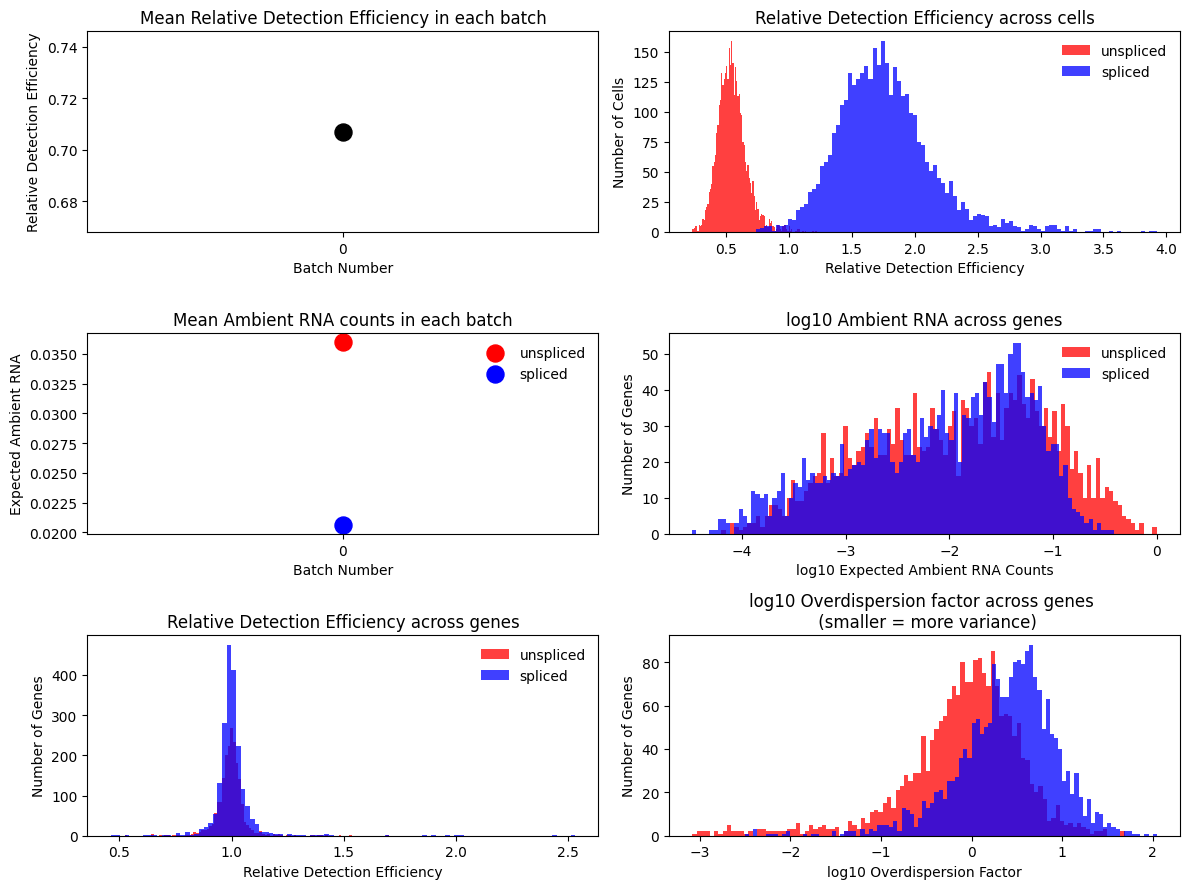

In [14]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [15]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.1433951
gamma_g mean: 1.2856714
beta_g mean: 1.5454558
lam_mi, all modules: 
 
 [[[ 5.66  5.59]]

 [[ 1.64  0.85]]

 [[ 3.4   5.92]]

 [[13.86 10.85]]

 [[ 0.57  1.96]]

 [[ 3.86  2.92]]

 [[14.28  4.5 ]]

 [[ 2.21  2.35]]

 [[ 3.45  3.46]]

 [[ 6.72  4.12]]

 [[ 0.51  0.81]]

 [[ 4.09  3.65]]

 [[ 2.18  2.07]]

 [[ 2.15  2.23]]

 [[ 2.3   2.46]]]


In [16]:
adata=mod.export_posterior_quantiles(adata, batch_size = len(adata.obs_names))

Computing posterior quantile 0.25, data batch:   0%|                                                                                                                   | 0/1 [00:00<?, ?it/s]


RuntimeError: expand(torch.cuda.FloatTensor{[1]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)